# Reconstruction

In [9]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
import matplotlib.pyplot as plt
import astra
import h5py
import os
import mrcfile
#from tvtk.api import tvtk
from mayavi import mlab
from IPython.display import Image
import sys
sys.path.append("../..") 
from cryoem.reconstruction import reconstruct
from cryoem.conversions import quaternion2euler

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1677566280016068682
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2455003161843531603
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13348251301422728129
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2279014400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5204687165716924448
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


---

In [4]:
RESULTS_DIR = "../../data/results_pipeline_5j0n_fullcvg_uniformS2_noise16"
initial_mrc_filename = "../../data/5j0n.mrc"
prefix = "5j0n_fullcvg_uniformS2_noise16"

In [5]:
data = np.load(f"{RESULTS_DIR}/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [6]:
# file with projections and angles
projections_filename = f"{RESULTS_DIR}/5j0n_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(projections_filename, 'r')
projections = data["Projections"]
angles_true = data['Angles']

In [7]:
def add_gaussian_noise(projections, noise_var):
    noise_sigma   = noise_var**0.5
    nproj,row,col = projections.shape
    gauss_noise   = np.random.normal(0,noise_sigma,(nproj,row,col))
    gauss_noise   = gauss_noise.reshape(nproj,row,col) 
    projections   = projections + gauss_noise
    return projections

NOISY_VAR = 16
# Add zero-mean Gaussian noise on the projections 
projections_noisy = add_gaussian_noise(projections, NOISY_VAR)
#projections = add_triangle_translation(projections, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION)

# Reconstruction with Ground-Truth Angles

In [8]:
reconstruction = reconstruct(projections[test_idx], 
                             angles_true[test_idx], 
                             mrc_filename=f"{RESULTS_DIR}/{prefix}_gt.mrc", 
                             initial_mrc_filename=initial_mrc_filename, 
                             overwrite=True)

Vol shape: [69, 57, 75]
Reconstruction voxel size: (3.6666667, 3.6666667, 3.6666667)
Initial voxel size: (3.6666667, 3.6666667, 3.6666667)
Header:
	mrc.header.cella: (275., 209., 253.)
	mrc.header.cellb: (90., 90., 90.)
	mrc.header.origin: (69.753, 63.1, 26.546001)
	mrc.header.ispg: 0
Reconstruction saved to: ../../data/results_pipeline_5j0n_fullcvg_uniformS2_noise16/5j0n_fullcvg_uniformS2_noise16_gt.mrc


In [8]:
# uncomment if you want to see the mayavi reconstruction visualization, we use chimera
# mlab.contour3d(reconstruction, transparent=True)
# mlab.colorbar(orientation='vertical')
# mlab.show()

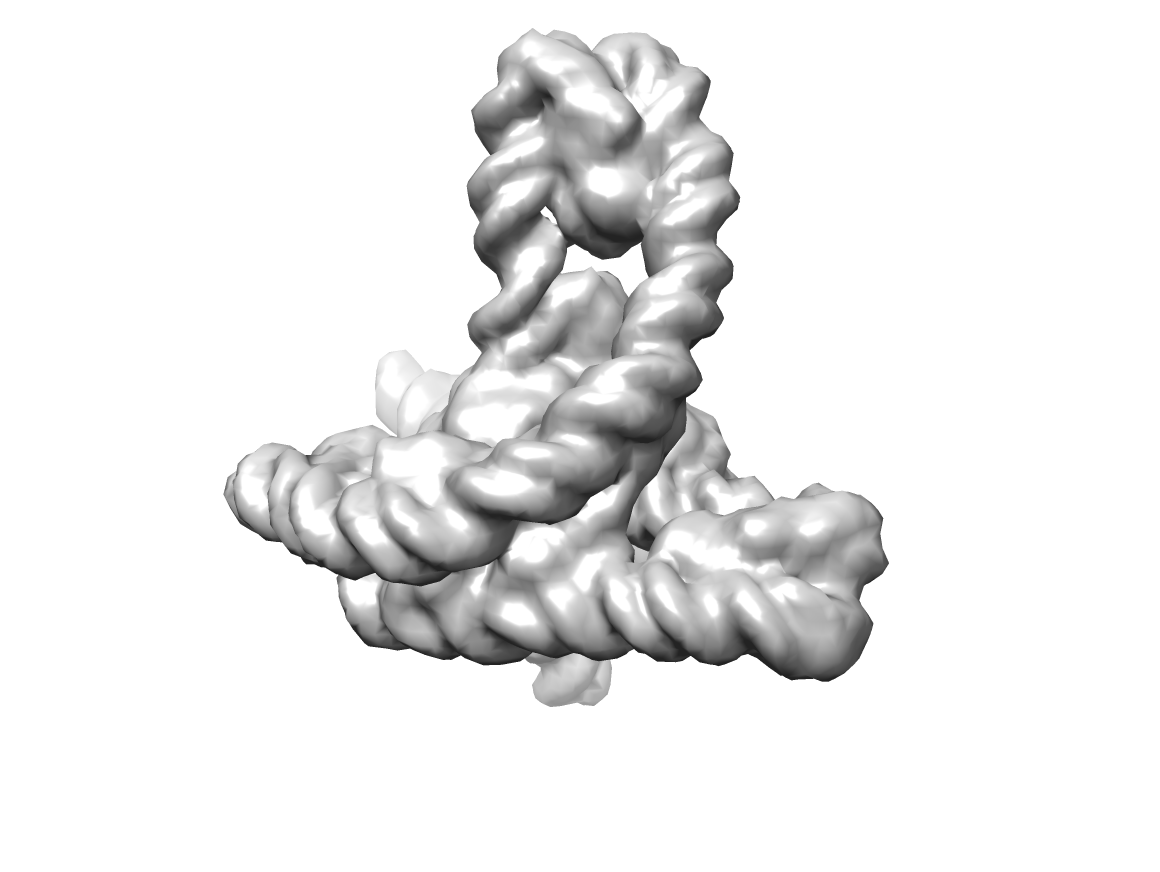

In [9]:
Image(filename=f'{RESULTS_DIR}/{prefix}_gt.png')

---

# Reconstruction with Ground-Truth Angles (Noisy)

In [9]:
reconstruction = reconstruct(projections_noisy[test_idx], 
                             angles_true[test_idx], 
                             mrc_filename=f"{RESULTS_DIR}/{prefix}_gt_noisy.mrc", 
                             initial_mrc_filename=initial_mrc_filename, 
                             overwrite=True)

Vol shape: [69, 57, 75]
Reconstruction voxel size: (3.6666667, 3.6666667, 3.6666667)
Initial voxel size: (3.6666667, 3.6666667, 3.6666667)
Header:
	mrc.header.cella: (275., 209., 253.)
	mrc.header.cellb: (90., 90., 90.)
	mrc.header.origin: (69.753, 63.1, 26.546001)
	mrc.header.ispg: 0
Reconstruction saved to: ../../data/results_pipeline_5j0n_fullcvg_uniformS2_noise16/5j0n_fullcvg_uniformS2_noise16_gt_noisy.mrc


In [8]:
# uncomment if you want to see the mayavi reconstruction visualization, we use chimera
# mlab.contour3d(reconstruction, transparent=True)
# mlab.colorbar(orientation='vertical')
# mlab.show()

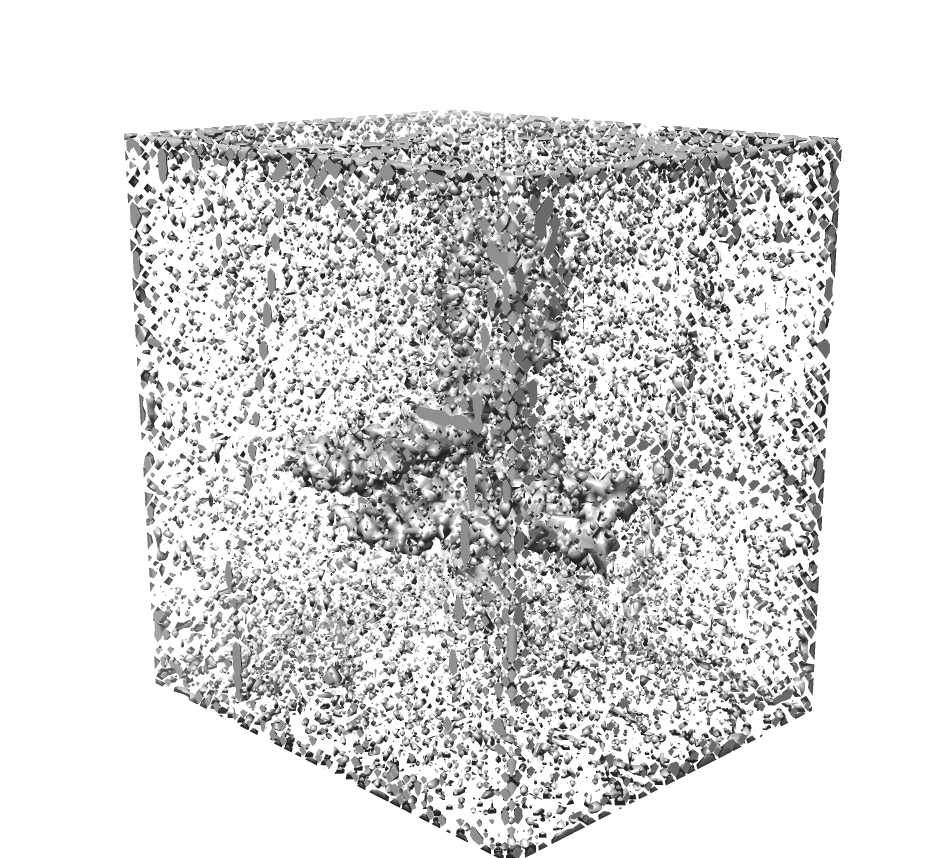

In [11]:
Image(filename=f'{RESULTS_DIR}/{prefix}_gt_noisy.png')

---

# Reconstruction with Random Angles

In [10]:
angles_random = np.random.rand(*angles_true.shape)
angles_random = np.multiply(angles_random, np.max(angles_true, axis=0))

reconstruction = reconstruct(projections[test_idx], 
                             angles_random[test_idx], 
                             mrc_filename=f"{RESULTS_DIR}/{prefix}_rand.mrc", 
                             initial_mrc_filename=initial_mrc_filename, 
                             overwrite=True)

Vol shape: [69, 57, 75]
Reconstruction voxel size: (3.6666667, 3.6666667, 3.6666667)
Initial voxel size: (3.6666667, 3.6666667, 3.6666667)
Header:
	mrc.header.cella: (275., 209., 253.)
	mrc.header.cellb: (90., 90., 90.)
	mrc.header.origin: (69.753, 63.1, 26.546001)
	mrc.header.ispg: 0
Reconstruction saved to: ../../data/results_pipeline_5j0n_fullcvg_uniformS2_noise16/5j0n_fullcvg_uniformS2_noise16_rand.mrc


In [11]:
# uncomment if you want to see the mayavi reconstruction visualization, we use chimera
# mlab.contour3d(reconstruction, transparent=True)
# mlab.colorbar(orientation='vertical')
# mlab.show()

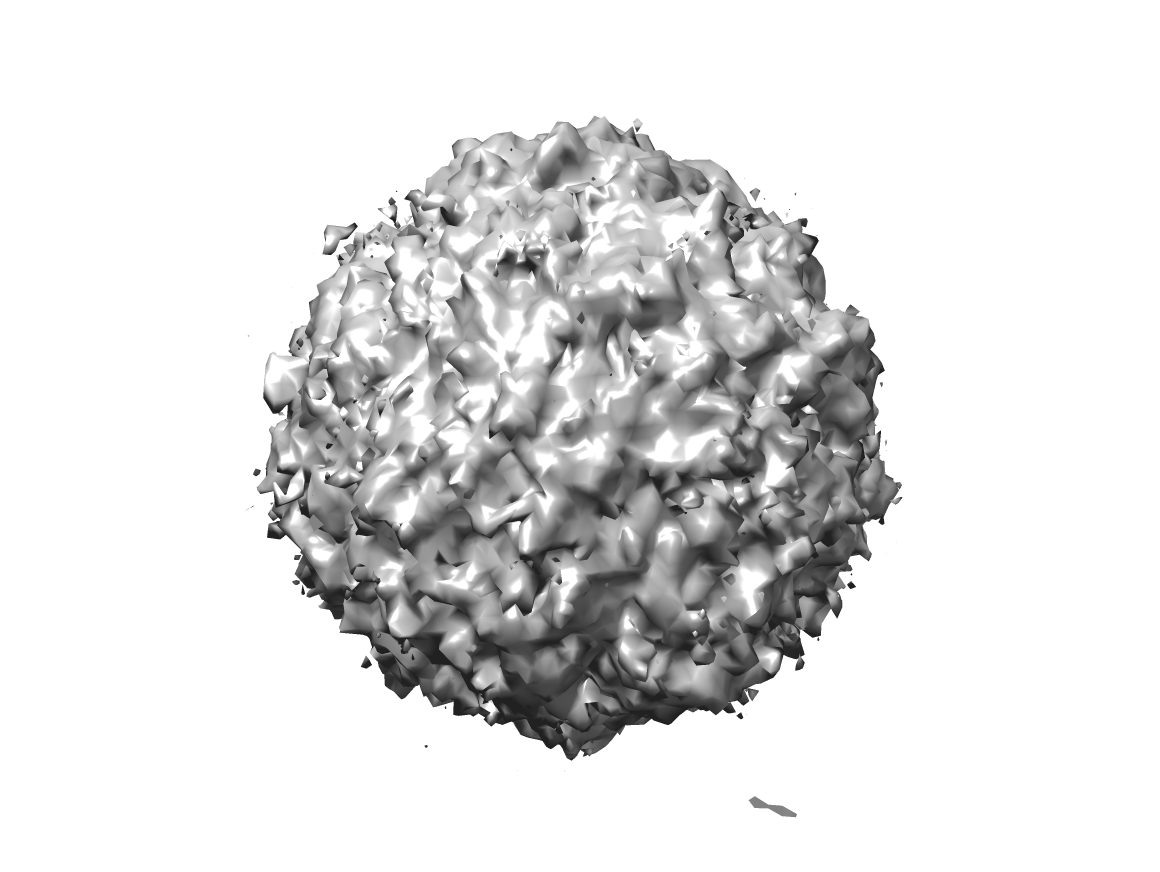

In [12]:
Image(filename=f'{RESULTS_DIR}/{prefix}_rand.png')

---

# Reconstruction before Angle Alignment

In [13]:
angles_predicted = np.load(f"{RESULTS_DIR}/angles_predicted.npy")
reconstruction = reconstruct(projections[test_idx], 
                             angles_predicted, 
                             mrc_filename=f"{RESULTS_DIR}/{prefix}_ap.mrc", 
                             initial_mrc_filename=initial_mrc_filename, 
                             overwrite=True)

Vol shape: [69, 57, 75]
Reconstruction voxel size: (3.6666667, 3.6666667, 3.6666667)
Initial voxel size: (3.6666667, 3.6666667, 3.6666667)
Header:
	mrc.header.cella: (275., 209., 253.)
	mrc.header.cellb: (90., 90., 90.)
	mrc.header.origin: (69.753, 63.1, 26.546001)
	mrc.header.ispg: 0
Reconstruction saved to: ../../data/results_pipeline_5j0n_fullcvg_uniformS2_noise16/5j0n_fullcvg_uniformS2_noise16_ap.mrc


In [14]:
# uncomment if you want to see the mayavi reconstruction visualization, we use chimera
# mlab.contour3d(reconstruction, transparent=True)
# mlab.colorbar(orientation='vertical')
# mlab.show()

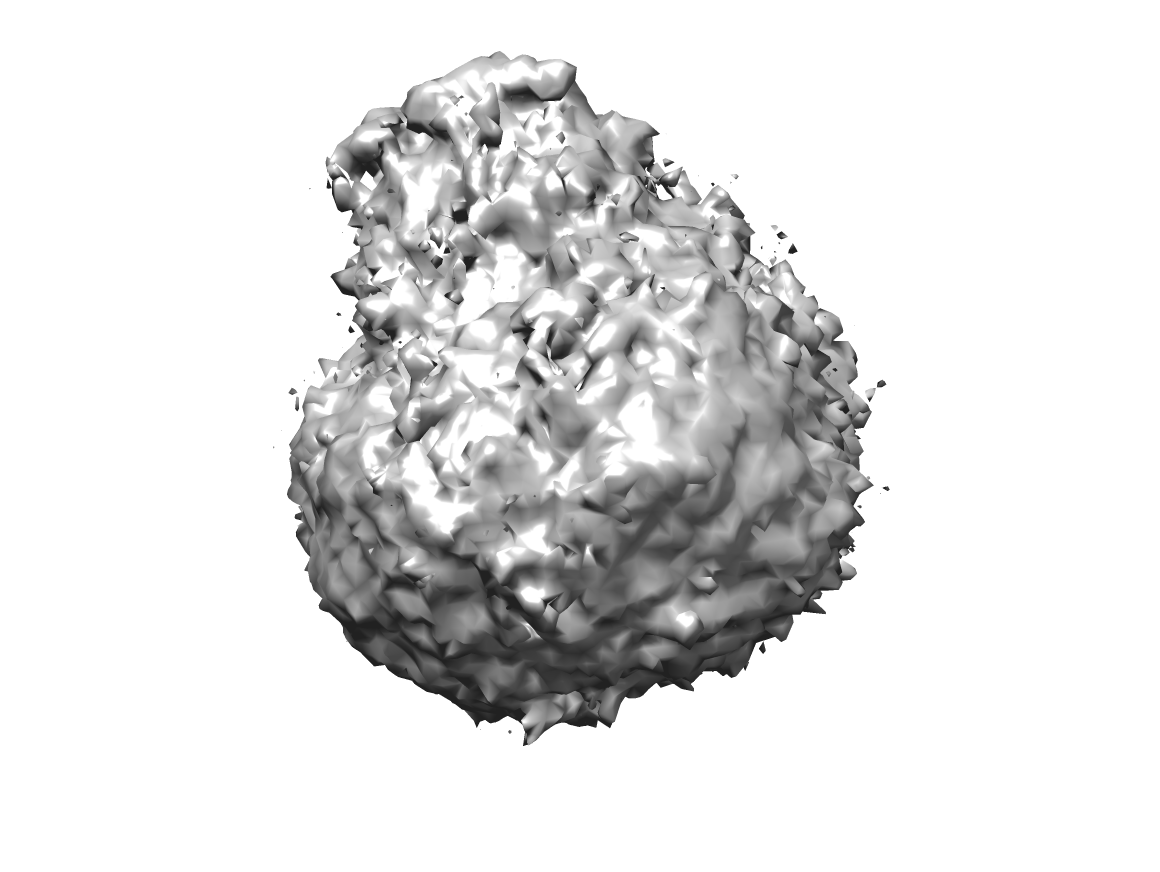

In [15]:
Image(filename=f'{RESULTS_DIR}/{prefix}_ap.png')

# Reconstruction after Angle Alignment

In [8]:
#projections = np.load("data/projections.npy")
angles_predicted = np.load(f"{RESULTS_DIR}/angles_predicted_rotated.npy")
reconstruction = reconstruct(projections[test_idx], 
                             angles_predicted, 
                             mrc_filename=f"{RESULTS_DIR}/{prefix}_apr2.mrc", 
                             initial_mrc_filename=initial_mrc_filename, 
                             overwrite=True)

Vol shape: [69, 57, 75]
Reconstruction voxel size: (3.6666667, 3.6666667, 3.6666667)
Initial voxel size: (3.6666667, 3.6666667, 3.6666667)
Header:
	mrc.header.cella: (275., 209., 253.)
	mrc.header.cellb: (90., 90., 90.)
	mrc.header.origin: (69.753, 63.1, 26.546001)
	mrc.header.ispg: 0
Reconstruction saved to: ../../data/results_pipeline_5j0n_fullcvg_uniformS2_noise16/5j0n_fullcvg_uniformS2_noise16_apr2.mrc


In [15]:
# uncomment if you want to see the mayavi reconstruction visualization, we use chimera
# mlab.contour3d(reconstruction, transparent=True)
# mlab.colorbar(orientation='vertical')
# mlab.show()

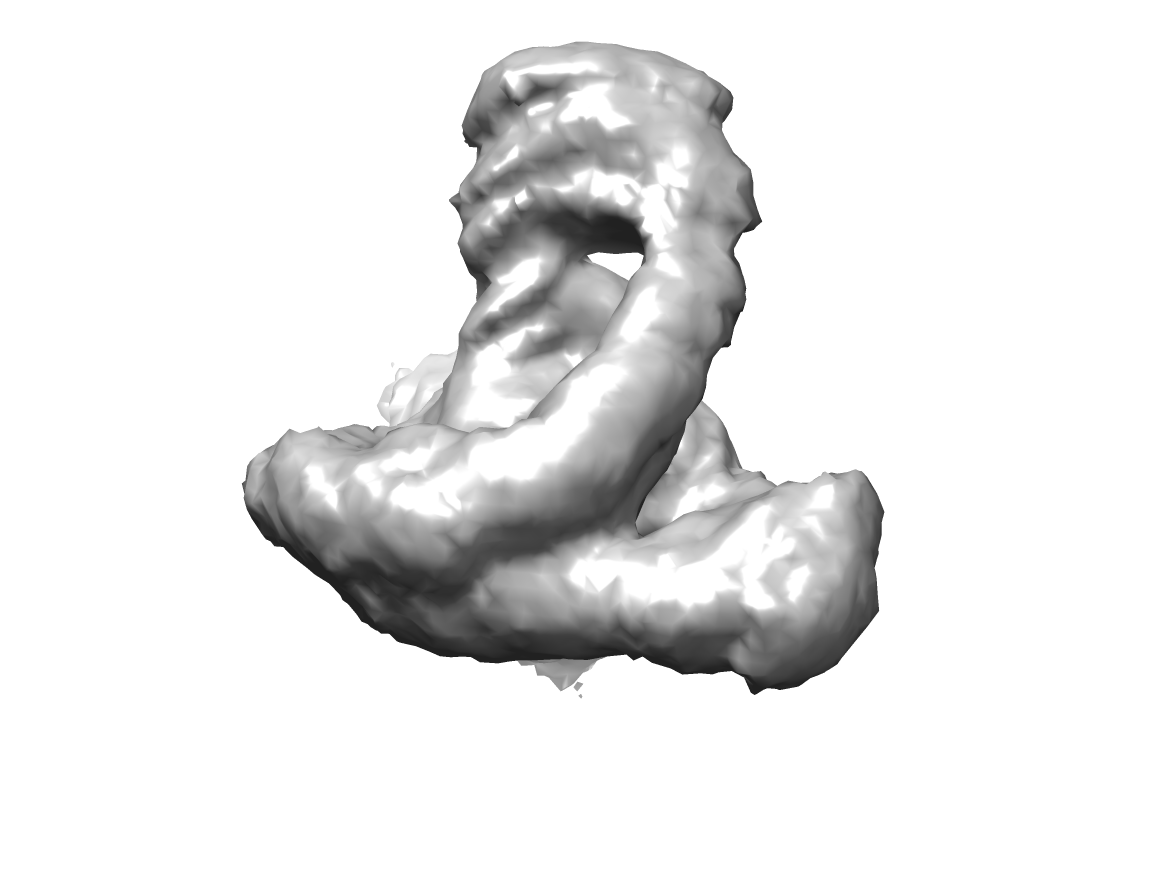

In [17]:
Image(filename=f'{RESULTS_DIR}/{prefix}_apr.png')

---

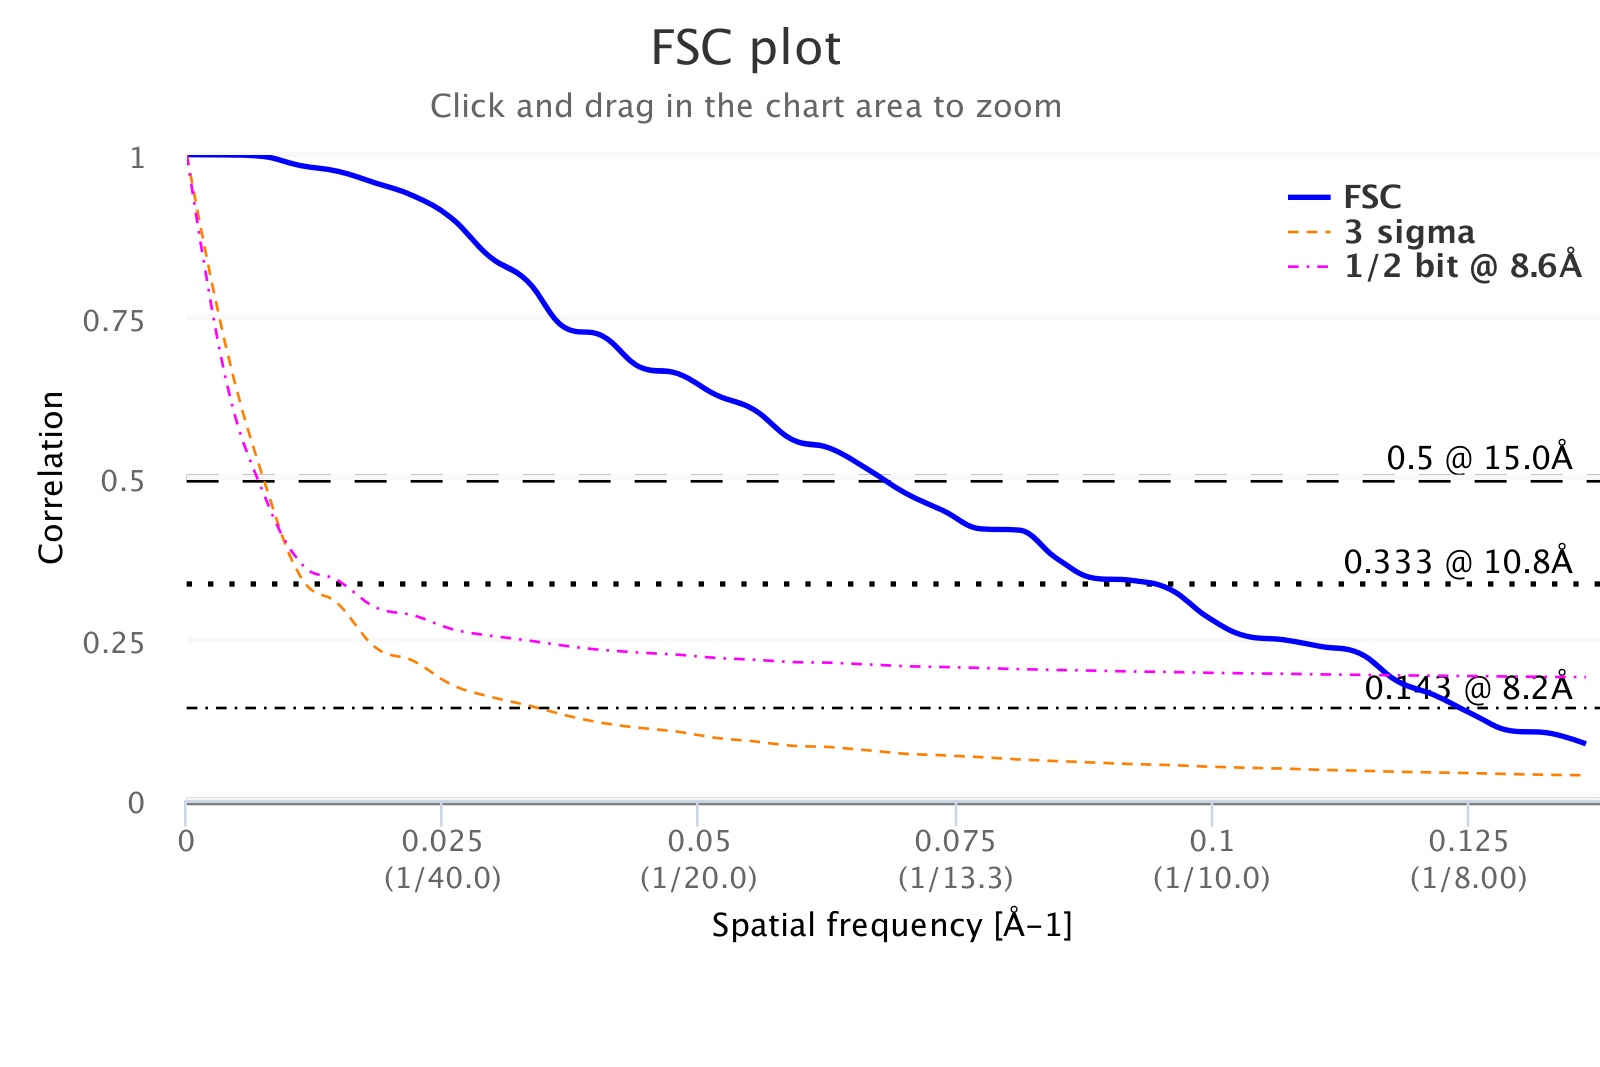

In [18]:
Image(filename=f'{RESULTS_DIR}/{prefix}_FSC_apr_init.png')